In [1]:
# Import necessary libraries for data manipulation and analysis
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
from datetime import datetime, timedelta # Date operations

#Import necessary libraries for transformations
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import skew, kurtosis

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt # Matplotlib for basic plotting
import seaborn as sns # Seaborn for enhanced visualization
import plotly.express as px # Plotly for interactive plots

# Import libraries for time series analysis and modeling
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test for stationarity check
from statsmodels.tsa.stattools import kpss # Kwiatkowski-Phillips-Schmidt-Shin Test for stationarity check
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX model for time series forecasting
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition for trend, seasonal, and residual components
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima #SARIMAX using pmdarima

# Import necessary libraries for computing acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from statsmodels.tsa.stattools import acf, pacf  # For computing autocorrelation and partial autocorrelation

#Import libraries for multicollineaarity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Import libraries for transformations
import joblib



In [2]:
from SARIMAX import remove_multicollinear, calculate_vif
import datascript
from datascript import load_data, split_data
import os

SARIMAX for Luzon
DATA PREPROCESSING

In [3]:
#Import the necessary files
base_path = os.path.dirname(os.path.abspath(datascript.__file__))  # Gets the current working directory
complete_luz_gwap = load_data("LUZ",'GWAP', features = False, transformed=False)
complete_luz_lwap = load_data("LUZ",'LWAP', features = False, transformed=False)

In [4]:
GWAP = load_data("LUZ",'GWAP', model='SARIMAX', features = False, transformed=True)
LWAP = load_data("LUZ",'LWAP', model='SARIMAX', features = False, transformed=True)

GWAP_transformed_features = load_data("LUZ",'GWAP', model='SARIMAX', features = True, transformed=True)

In [5]:
%run SARIMAX.py
#Prepare exogenous variables and check for multicollinearity
full_transformed_exog = GWAP_transformed_features.drop(columns=['GWAP'])
full_transformed_exog = full_transformed_exog.shift(1)
full_transformed_exog = full_transformed_exog.fillna(0)
full_exog_train, full_exog_test = split_data(full_transformed_exog, False)

exog_train = remove_multicollinear(full_exog_train, 10)
calculate_vif(exog_train)

final_exog = drop_unmatched_columns(full_transformed_exog, exog_train)

Dropping TMIN_Tanay with VIF of 108.33328364846425
Dropping TMAX_Clark with VIF of 93.05653071843075
Dropping TMAX_NAIA with VIF of 77.13698049203796
Dropping TMIN_Clark with VIF of 61.98790916803449
Dropping TMAX_Tayabas with VIF of 61.490494337799426
Dropping TMIN_NAIA with VIF of 56.57052248213269
Dropping TMAX_CLSU with VIF of 54.61911408613607
Dropping TMAX_Science Garden with VIF of 53.292559557436114
Dropping TMAX_Calapan with VIF of 52.362281365321415
Dropping TMIN_Casiguran with VIF of 51.53854389567617
Dropping TMAX_Tanay with VIF of 44.26876807875707
Dropping Demand with VIF of 40.63564443324962
Dropping TMIN_CLSU with VIF of 35.74155225851787
Dropping TMAX_Ambulong with VIF of 30.619134666121955
Dropping TMIN_Calapan with VIF of 27.36782045475102
Dropping TMAX_Cubi Point with VIF of 24.664842924298526
Dropping TMIN_Cubi Point with VIF of 24.388953143442215
Dropping Reserve_GWAP_Ru with VIF of 22.364813350706097
Dropping TMAX_Casiguran with VIF of 20.534308013672657
Dropping

In [6]:
#Prepare the necessary datasets
#Target Variables
GWAP_train, GWAP_test = split_data(GWAP, False)
LWAP_train, LWAP_test = split_data(LWAP, False)

#Untransformed variables for verification 
untransformed_GWAP_train, untransformed_GWAP_test = split_data(complete_luz_gwap, False)
untransformed_LWAP_train, untransformed_LWAP_test = split_data(complete_luz_lwap, False)



In [8]:
#Plotting Train LWAP ang GWAP
# Create the line plot
gwap_plot = px.line(GWAP_train, x=GWAP_train.index, y='GWAP')
lwap_plot = px.line(LWAP_train, x=LWAP_train.index, y='LWAP')
# Set the title using the ticker value
gwap_plot.update_layout(title=f"Luzon GWAP")
lwap_plot.update_layout(title=f"Luzon LWAP")
# Display the plot
gwap_plot.show()
lwap_plot.show()

Differencing

In [7]:
%run SARIMAX.py

#Checking for stationarity in GWAP data
differenced_GWAP = perform_differencing(GWAP_train, GWAP)
differenced_LWAP = perform_differencing(LWAP_train, LWAP)

GWAP_train, GWAP_test = split_data(differenced_GWAP, False)
LWAP_train, LWAP_test = split_data(differenced_LWAP, False)

Data is stationary after differencing 0 times.
Data is stationary after differencing 0 times.


C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')


In [8]:
#Perform differencing on train exogenous data
diff_full_exog = perform_df_differencing(exog_train, final_exog)
diff_full_exog = diff_full_exog.fillna(0)
exog_train, exog_test = split_data(diff_full_exog, False)

C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:96: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c")
C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:96: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression="c")
C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:96: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c")
C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:96: InterpolationWarning: The test statistic is outside of the range of p-values av

Column 'FLOW_LUZ' is stationary after differencing 0 times.
Column 'Reserve_GWAP_Fr' is stationary after differencing 0 times.
Column 'Reserve_GWAP_Rd' is stationary after differencing 1 times.
Column 'Reserve_GWAP_Dr' is stationary after differencing 1 times.
Column 'RAINFALL_Cubi Point' is stationary after differencing 0 times.
Column 'RAINFALL_NAIA' is stationary after differencing 1 times.
Column 'RAINFALL_Science Garden' is stationary after differencing 0 times.
Column 'TMIN_Science Garden' is stationary after differencing 1 times.
Column 'RAINFALL_San Jose' is stationary after differencing 0 times.


C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:96: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c")
C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:96: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression="c")
C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:96: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c")
C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:96: InterpolationWarning: The test statistic is outside of the range of p-values av

Column 'TMIN_San Jose' is stationary after differencing 1 times.
Column 'RAINFALL_Tayabas' is stationary after differencing 0 times.
Column 'RAINFALL_CLSU' is stationary after differencing 1 times.
Column 'RAINFALL_Tanay' is stationary after differencing 1 times.
Column 'RAINFALL_Ambulong' is stationary after differencing 0 times.
Column 'RAINFALL_Casiguran' is stationary after differencing 1 times.
Column 'RAINFALL_Clark' is stationary after differencing 1 times.
Column 'RAINFALL_Calapan' is stationary after differencing 0 times.


C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:96: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c")
C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:96: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c")
C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:96: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c")
C:\Users\Jojie\Desktop\School\Senior\Thesis\sarimax (03-12)\SARIMAX.py:96: InterpolationWarning: The test statistic is outside of the range of p-values av

Order Specification

The ACF for GWAP is seen below
The PACF for GWAP is seen below


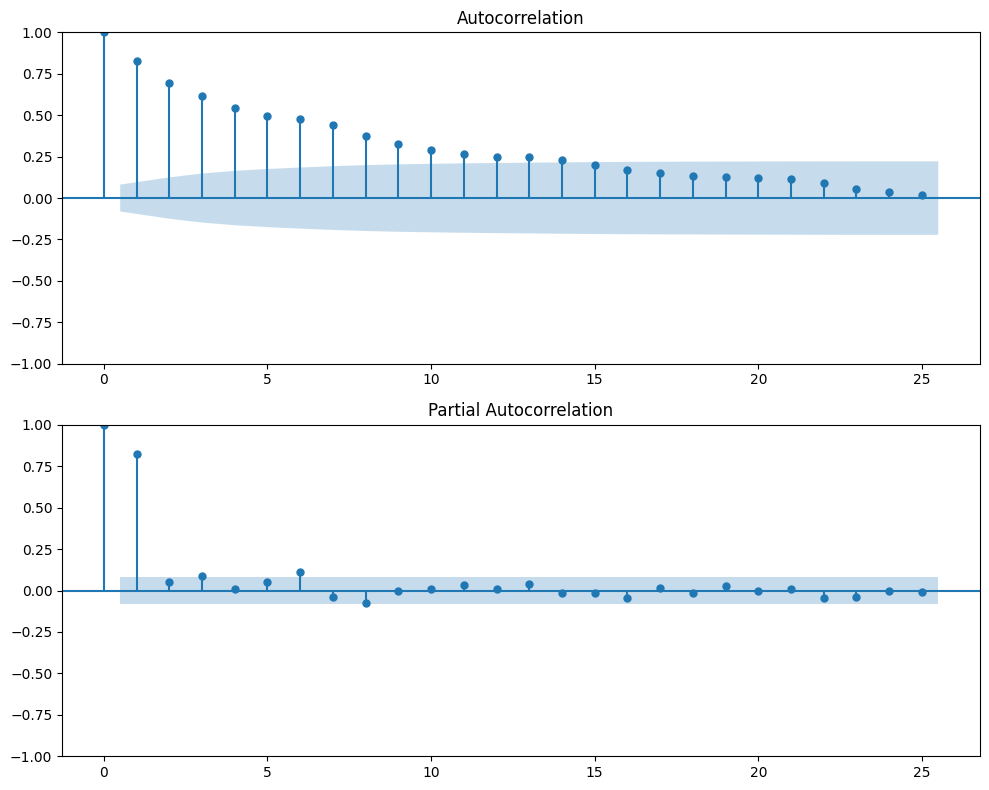

The ACF for LWAP is seen below
The PACF for LWAP is seen below


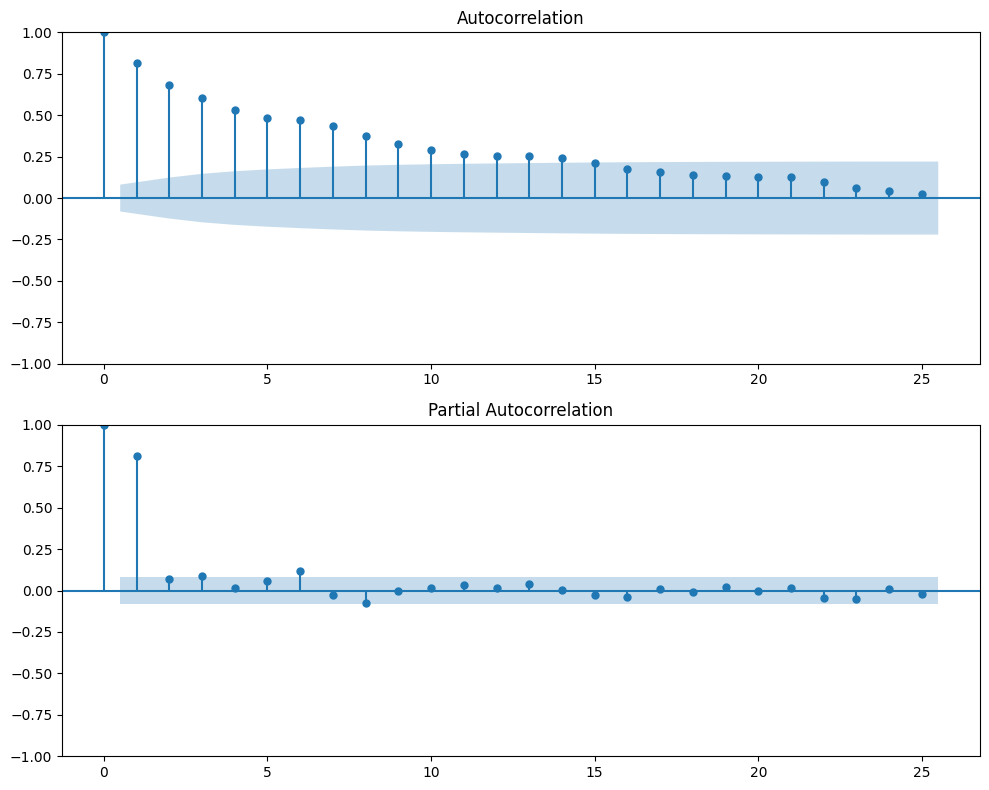

In [12]:
%run SARIMAX.py
plot_orders(GWAP_train, lags=25, alpha=0.05, var='GWAP')
plot_orders(LWAP_train, lags=25, alpha=0.05, var='LWAP')

GWAP and LWAP Forecasting

In [ ]:
%run SARIMAX.py
#Run seasonal_auto_arima function on GWAP 
#Use max_p and max_q based on acf and pacf plots
GWAP_sarimax = seasonal_auto_arima(GWAP_train, max_p=1, max_d=2, max_q=13, exog_data=exog_train )

#Display results of previous function
GWAP_sarimax

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecatio

The model with the lowest AIC has a seasonal period of 6 and an AIC of -1070.7818442949656


ARIMA(maxiter=300, method='powell', order=(1, 1, 1), scoring_args={},
      seasonal_order=(0, 0, 1, 6), suppress_warnings=True)

In [ ]:
%run SARIMAX.py
#Run seasonal_auto_arima function on GWAP 
#Use max_p and max_q based on acf and pacf plots
LWAP_sarimax = seasonal_auto_arima(LWAP_train, max_p=1, max_d=2, max_q=14, exog_data=exog_train )

#Display results of previous function
LWAP_sarimax

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecatio

The model with the lowest AIC has a seasonal period of 7 and an AIC of -1030.783221940742


ARIMA(maxiter=300, method='powell', order=(1, 1, 1), scoring_args={},
      seasonal_order=(1, 0, 0, 7), suppress_warnings=True)

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -0.953165
         Iterations: 11
         Function evaluations: 2065
                                     SARIMAX Results                                     
Dep. Variable:                              GWAP   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 6)   Log Likelihood                 556.649
Date:                           Sat, 15 Mar 2025   AIC                          -1071.297
Time:                                   15:00:16   BIC                           -979.565
Sample:                               01-01-2022   HQIC                         -1035.542
                                    - 08-07-2023                                         
Covariance Type:                             opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -0.928000
         Iterations: 11
         Function evaluations: 2081
                                     SARIMAX Results                                      
Dep. Variable:                               LWAP   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                 541.952
Date:                            Sat, 15 Mar 2025   AIC                          -1041.904
Time:                                    15:00:46   BIC                           -950.172
Sample:                                01-01-2022   HQIC                         -1006.148
                                     - 08-07-2023                                         
Covariance Type:                              opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

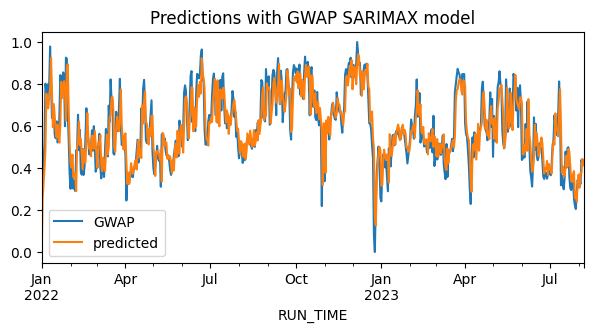

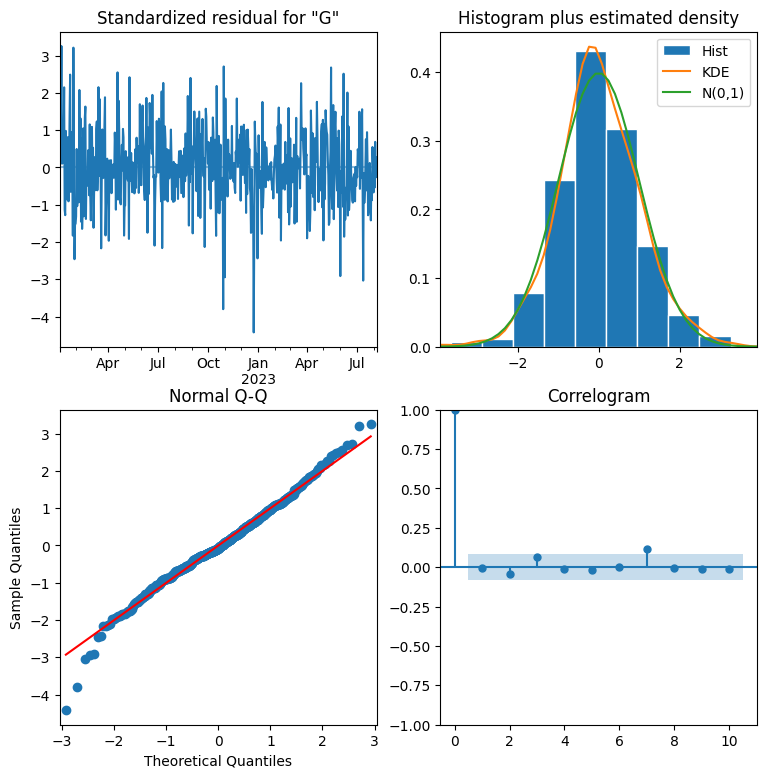

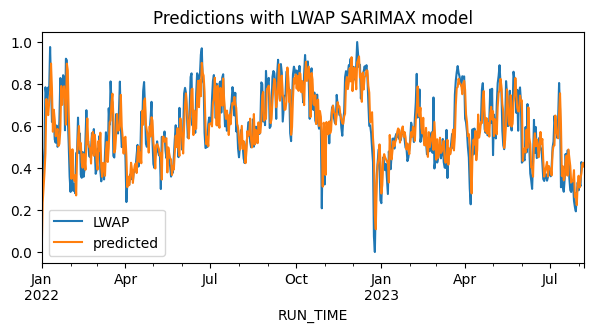

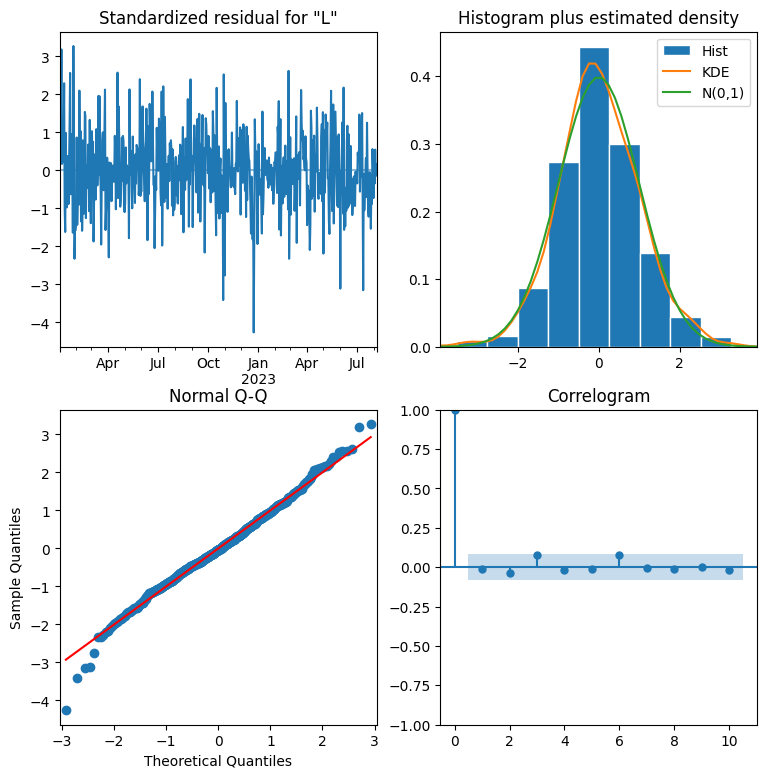

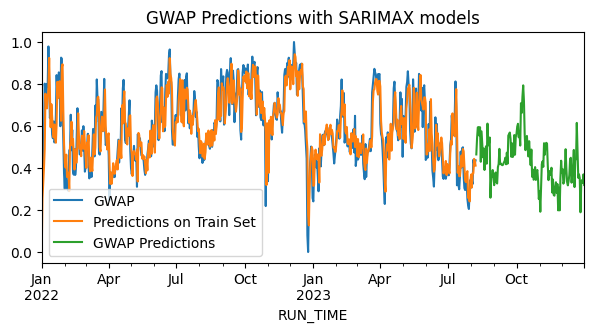

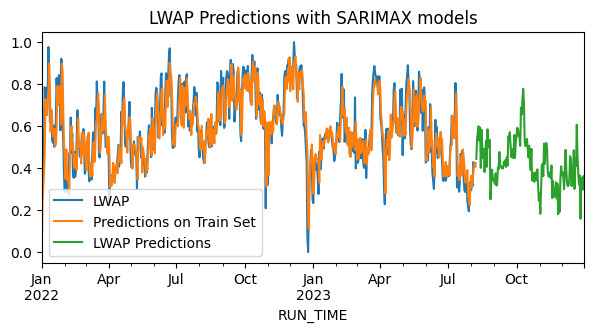

In [9]:
#Optimized orders for GWAP are (1,1,1)(0,0,1,6) and for LWAP are (1,1,1)(1,0,0)(7)
#This function fits the model and plots predictions on the train set; shows the summary of results and residuals diagnostics; and predicts on train set
%run SARIMAX.py

gwap_predictions, lwap_predictions, gwap_train_predict, lwap_train_predict = fit_SARIMAX(gwap_endog=GWAP_train, lwap_endog= LWAP_train, train_exog=exog_train, gwap_order=(1,1,1), gwap_seasonal_order=(0,0,1,6), lwap_order = (1,1,1), lwap_seasonal_order=(1,0,0,7), GWAP_test=GWAP_test, LWAP_test=LWAP_test, exog_test = exog_test)


Applying inverse transformations

In [10]:
#Covert predictions series to dataframe

gwap_predictions_df = gwap_predictions.to_frame(name='GWAP')
lwap_predictions_df = gwap_predictions.to_frame(name='LWAP')

In [11]:
%run transformscript.py

inverse_gwap_predictions = inverse_transform_data(gwap_predictions_df, 'SARIMAX', 'LUZ', 'GWAP')
inverse_lwap_predictions = inverse_transform_data(lwap_predictions_df, 'SARIMAX', 'LUZ', 'LWAP')

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Mean Absolute Error (MAE) on Test Set for GWAP: 1037.2914453430942
Root Mean Squared Error (RMSE) on Test Set for GWAP: 1759.2181324755443
Mean Absolute Percentage Error (MAPE) on Test Set for GWAP: 18.151759257515504


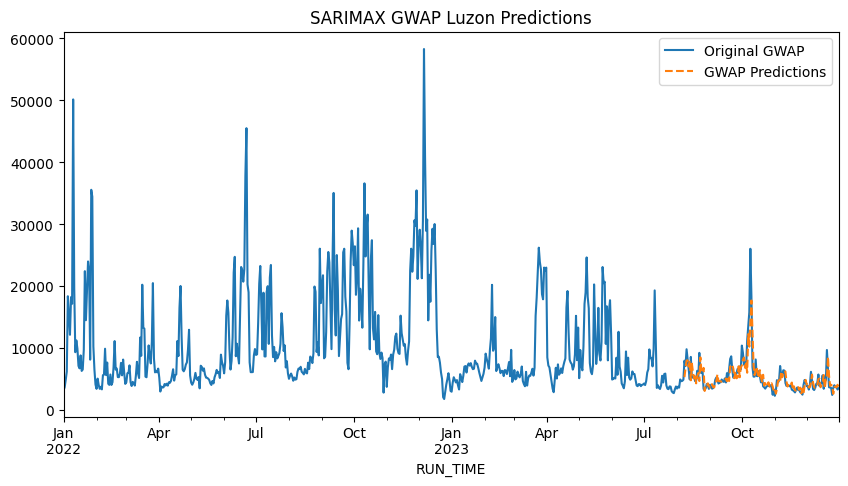

Mean Absolute Error (MAE) on Test Set for LWAP: 1145.959263239814
Root Mean Squared Error (RMSE) on Test Set for LWAP: 1864.730604634761
Mean Absolute Percentage Error (MAPE) on Test Set for LWAP: 19.92696044948295


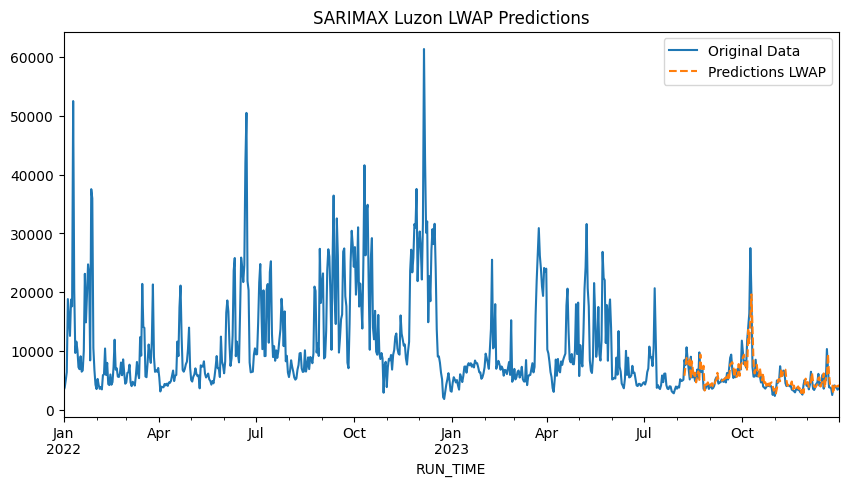

In [12]:
%run SARIMAX.py
gwap_mae_test, gwap_rmse_test, mape_test_gwap, mape_test_lwap, lwap_rmse_test, lwap_rmse_test = evaluate_models(complete_luz_gwap, complete_luz_lwap, GWAP_test_original = untransformed_GWAP_test, GWAP_predictions_inverse= inverse_gwap_predictions, LWAP_test_original=untransformed_LWAP_test, LWAP_predictions_inverse=inverse_lwap_predictions, Region = 'Luzon')

In [13]:
inverse_gwap_predictions.to_csv('luz-gwap-predictions.csv', index=False)
inverse_lwap_predictions.to_csv('luz-lwap-predictions.csv', index=False)